100%|██████████| 9912422/9912422 [00:00<00:00, 87426582.37it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35998720.30it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 19554589.99it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4346458.77it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1, Batch 0, Loss: 0.1884072721004486
Epoch 2, Batch 0, Loss: 0.1550343930721283
Epoch 3, Batch 0, Loss: 0.1315760612487793
Epoch 4, Batch 0, Loss: 0.1128007024526596
Epoch 5, Batch 0, Loss: 0.09704812616109848
Epoch 6, Batch 0, Loss: 0.08383876830339432
Epoch 7, Batch 0, Loss: 0.07275141775608063
Epoch 8, Batch 0, Loss: 0.06344036012887955
Epoch 9, Batch 0, Loss: 0.05565086007118225
Epoch 10, Batch 0, Loss: 0.049087539315223694
Epoch 10, Loss: 0.049087539315223694
Epoch 1, Batch 0, Loss: 0.2725071310997009
Epoch 2, Batch 0, Loss: 0.225107803940773
Epoch 3, Batch 0, Loss: 0.18960444629192352
Epoch 4, Batch 0, Loss: 0.16288502514362335
Epoch 5, Batch 0, Loss: 0.14195537567138672
Epoch 6, Batch 0, Loss: 0.12386523932218552
Epoch 7, Batch 0, Loss: 0.10839732736349106
Epoch 8, Batch 0, Loss: 0.09519632160663605
Epoch 9, Batch 0, Loss: 0.08385413885116577
Epoch 10, Batch 0, Loss: 0.07414676994085312
Epoch 10, Lo

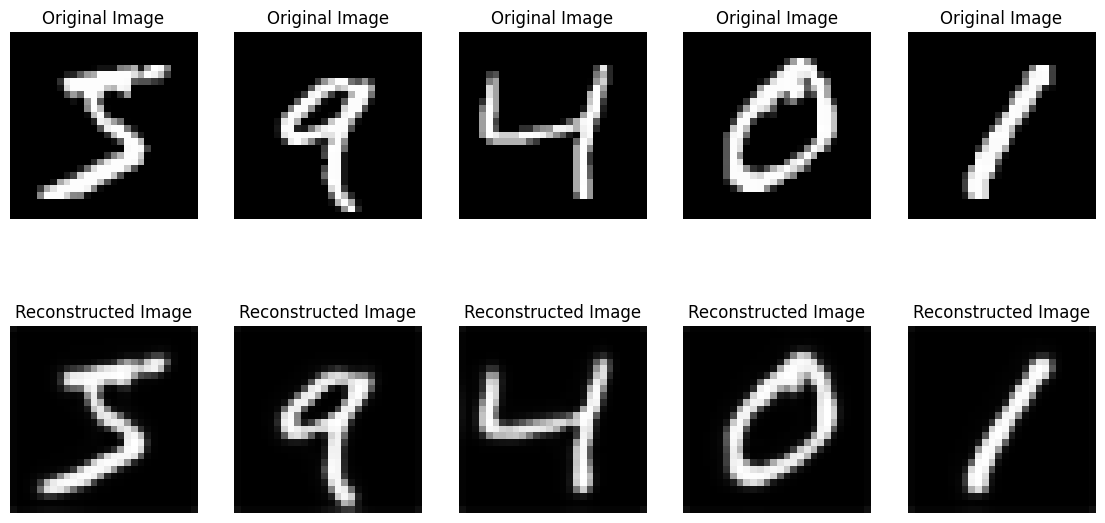

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# Function to upscale the images for better visualization
def upscale_image(image, scale_factor=4):
    image = image.squeeze().detach().numpy()
    return image

class SuperResolutionAutoencoder(nn.Module):
    def __init__(self):
        super(SuperResolutionAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Perform grid search for hyperparameters
results = []
# Define the number of images you want to load from MNIST
num_images = 5
num_epochs = 10  # Adjust the number of epochs as needed

# Grid of hyperparameters to search
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
for lr in learning_rates:
    for batch_size in batch_sizes:
        # Load the MNIST dataset
        transform = transforms.Compose([transforms.ToTensor()])
        trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        subset_indices = list(range(num_images))
        subset_mnist_dataset = Subset(trainset, subset_indices)
        trainloader = DataLoader(subset_mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

        # Initialize the model, loss function, and optimizer
        model = SuperResolutionAutoencoder()
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Training loop
        for epoch in range(num_epochs):
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                inputs, _ = data
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                if i % 10 == 0:
                    print(f'Epoch {epoch + 1}, Batch {i}, Loss: {loss.item()}')

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')

        # Store the results for this combination
        results.append({
            'lr': lr,
            'batch_size': batch_size,
            'final_loss': running_loss / len(trainloader)
        })

# Find the best combination based on validation loss or other metrics
best_result = min(results, key=lambda x: x['final_loss'])

print('Best hyperparameters:')
print(f'Learning Rate: {best_result["lr"]}')
print(f'Batch Size: {best_result["batch_size"]}')
print(f'Final Loss: {best_result["final_loss"]}')

# Display original and reconstructed images for comparison using the best hyperparameters
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
subset_indices = list(range(num_images))
subset_mnist_dataset = Subset(trainset, subset_indices)
trainloader = DataLoader(subset_mnist_dataset, batch_size=num_images, shuffle=True, num_workers=2)

# Initialize the model with the best hyperparameters
model = SuperResolutionAutoencoder()
optimizer = optim.Adam(model.parameters(), lr=best_result["lr"])
criterion = nn.MSELoss()
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 0:
            print(f'Epoch {epoch + 1}, Batch {i}, Loss: {loss.item()}')

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')

print('Finished Training with Best Hyperparameters')

# Display original and reconstructed images for comparison
data_iter = iter(trainloader)
images, _ = next(data_iter)
reconstructed_images = model(images)

# Display images in a grid with larger size and no coordinate labels
plt.figure(figsize=(14, 7))
for i in range(num_images):
    plt.subplot(2, num_images, i + 1)
    plt.title('Original Image')
    plt.axis('off')  # Turn off the coordinate labels
    plt.imshow(images[i].squeeze(), cmap='gray')

    plt.subplot(2, num_images, i + num_images + 1)
    plt.title('Reconstructed Image')
    plt.axis('off')  # Turn off the coordinate labels
    plt.imshow(upscale_image(reconstructed_images[i]), cmap='gray')

plt.show()
